In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, MaxPool2D, Reshape, Input
from keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

del y_train, y_test

In [0]:
# 32 -> 64 -> 128 -> 256

def create_encoder(img_shape, hidden_size):
  
  encoder = Sequential()
  encoder.add(Conv2D(32, (3, 3), activation='elu', padding='same', input_shape=img_shape))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
  encoder.add(MaxPool2D())
  encoder.add(Flatten())
  encoder.add(Dense(hidden_size))
  
  return encoder

# 128 -> 64 -> 32 -> 1

def create_decoder(img_shape, hidden_size):

  decoder = Sequential()
  decoder.add(Dense(np.prod(img_shape), input_shape=(hidden_size, )))
  decoder.add(Reshape(img_shape))
  decoder.add(Conv2DTranspose(128, (3, 3), padding='same', strides=1, activation='elu'))
  decoder.add(Conv2DTranspose(64, (3, 3), padding='same', strides=1, activation='elu'))
  decoder.add(Conv2DTranspose(32, (3, 3), padding='same', strides=1, activation='elu'))
  decoder.add(Conv2DTranspose(1, (3, 3), padding='same', strides=1, activation=None))
  
  print("decoder output_shape : ", decoder.output_shape)
  return decoder

In [4]:
img_shape = X_train[0].shape
print("img_shape : ", img_shape)
hidden_size = 32

encoder = create_encoder(img_shape, hidden_size)
decoder = create_decoder(img_shape, hidden_size)

print("\nEncoder network : ")
encoder.summary()

print("\nDecoder network : ")
decoder.summary()

img_shape :  (28, 28, 1)
decoder output_shape :  (None, 28, 28, 1)

Encoder network : 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_______________________________________________________

In [5]:
inputs = Input(img_shape)
code = encoder(inputs)
reconstruction = decoder(code)

model = Model(inputs=inputs, outputs=reconstruction)
model.compile(optimizer='adamax', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                396064    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         119697    
Total params: 515,761
Trainable params: 515,761
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, X_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0169
Epoch 2/5
 7072/60000 [==>...........................] - ETA: 56s - loss: 0.0083

60000/60000 [==============================] - 64s 1ms/step - loss: 0.0073
Epoch 3/5
15520/60000 [======>.......................] - ETA: 47s - loss: 0.0064

60000/60000 [==============================] - 64s 1ms/step - loss: 0.0062
Epoch 4/5
19296/60000 [========>.....................] - ETA: 43s - loss: 0.0057

60000/60000 [==============================] - 63s 1ms/step - loss: 0.0055
Epoch 5/5
20128/60000 [=========>....................] - ETA: 42s - loss: 0.0052

60000/60000 [==============================] - 64s 1ms/step - loss: 0.0051


In [7]:
score = model.evaluate(X_test, X_test) # MSE score
print(score)

10000/10000 [==============================] - 3s 311us/step
0.004779346796125174


In [0]:
def visualize_results(img, encoder, decoder):
  code = encoder.predict(img[None])[0] # [0] olmadan (1, 32)'lik bir dizi oldugu icin 0. indeksini aliyoruz.
                                       # (32, )'lik bir dizi oluyor.
  reconstruction = decoder.predict(code[None])[0]
  
  plt.subplot(1, 3, 1)
  plt.title('Original')
  plt.imshow(img.reshape(28, 28))
  plt.axis('off')
  
  plt.subplot(1, 3, 2)
  plt.title('Code')
  plt.imshow(code.reshape([code.shape[-1]//2, -1]))
  plt.axis('off')
  
  plt.subplot(1, 3, 3)
  plt.title('Reconstructed')
  plt.imshow(reconstruction.reshape(28, 28))
  plt.axis('off')
  
  plt.show()

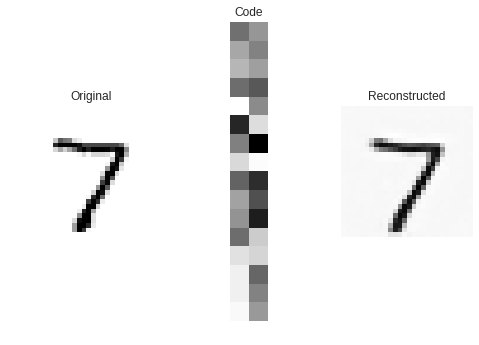

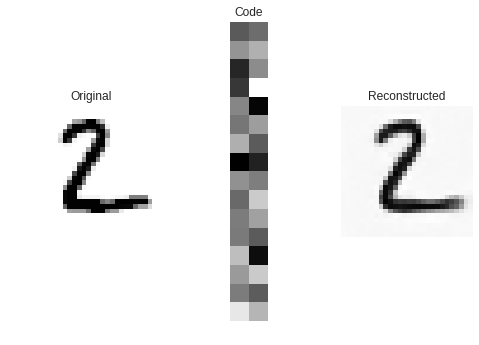

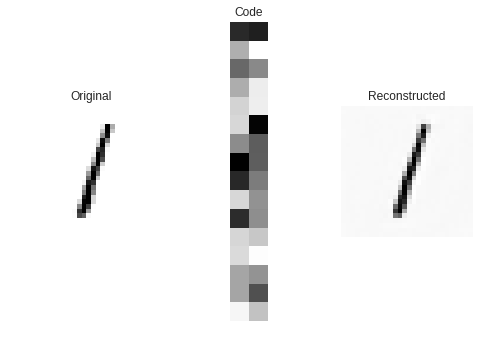

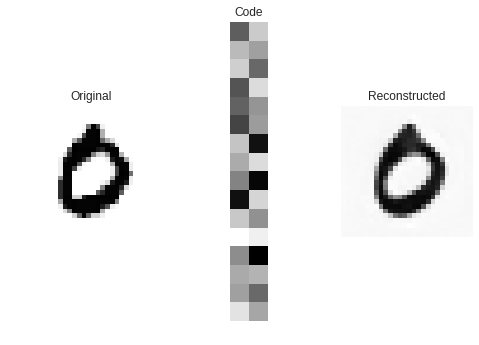

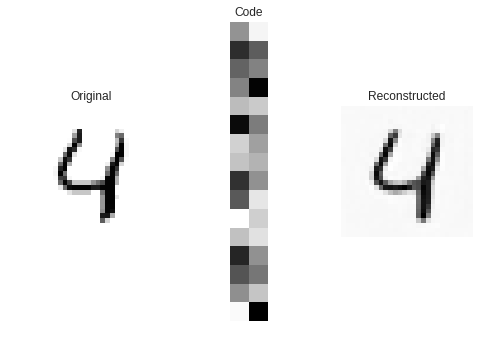

In [9]:
for i in range(5):
  visualize_results(X_test[i], encoder, decoder)